In [1]:
from ase.io import read
import ase
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from rascal.representations import SphericalExpansion, SphericalInvariants
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from rascal.utils import (WignerDReal, ClebschGordanReal, 
                          spherical_expansion_reshape, spherical_expansion_conjugate,
                          lm_slice, real2complex_matrix, xyz_to_spherical, spherical_to_xyz)

In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nigam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

This notebook provides examples of the kind of manipulations that need to be applied to rotate structures, spherical expansion coefficients and higher-order equivariants, which are useful to test equivariance of features and kernels, and in general to manipulate invariant and equivariant properties. 

The basic idea, using notation from [Musil et al. (2021)](http://doi.org/10.1021/acs.chemrev.1c00021), is that if a structure $A$ is acted upon with a rotation $\hat{R}$, _equivariant_ features transform in a prescribed way, i.e.
$$
|\hat{R} A; \lambda \mu\rangle = \sum_{\mu'} [D(\hat{R})^\lambda_{\mu\mu'}]^\star | A; \lambda \mu.\rangle
$$

$D(\hat{R})^\lambda_{\mu\mu'}$ are the elements of a _Wigner D matrix_ that enact rotations of spherical harmonics $Y^\mu_\lambda$. Given that spherical harmonics are irreducible representations of the rotation group, any property or set of features can be decomposed into terms that transform like one or more sets of $Y^\mu_\lambda$.

Using ML models based on equivariant features is useful because it allows building basic symmetries of the target properties into the model structure, improving the data efficiency of the models. 

# Spherical expansion coefficients

This section demonstrates the manipulations of spherical expansion coefficients, the simplest equivariant way of representing an environment $A_i$ centered on atom $i$,
$$
\langle a n l m|A; \rho_i\rangle = \sum_{j\in A_i} \delta_{aa_j}
\int \mathrm{d}\mathbf{r} \langle n|r\rangle \langle lm|\hat{\mathbf{r}}\rangle
\langle \mathbf{r} | \mathbf{r}_{ji}; g\rangle
$$
Note that $\langle lm|\hat{\mathbf{r}}\rangle$ is the complex conjugate of a spherical harmonic, and so strictly speaking the equivariant is $\langle a n l m|A; \rho_i\rangle^\star$. This section also discusses briefly some of the subtleties that arise when converting expressions based on complex-valued spherical harmonics into their real-valued counterparts, that are used in the librascal implementation.

In [2]:
# imports also some internals to demonstrate manually some CG manipulations
from rascal.utils.cg_utils import _r2c as r2c
from rascal.utils.cg_utils import _c2r as c2r
from rascal.utils.cg_utils import _cg as clebsch_gordan
from rascal.utils.cg_utils import _rotation as rotation
from rascal.utils.cg_utils import _wigner_d as wigner_d

## Loads the structures

In [3]:
import urllib.request
# a collection of distorted allyl alcohol molecules from the ANI-1 dataset 
# (see https://github.com/isayev/ANI1_dataset) with energies and forces computed using DFTB+ 
# (see https://www.dftbplus.org/)
url = 'https://raw.githubusercontent.com/cosmo-epfl/librascal-example-data/833b4336a7daf471e16993158322b3ea807b9d3f/inputs/molecule_conformers_dftb.xyz'
# Download the file from `url`, save it in a temporary directory and get the
# path to it (e.g. '/tmp/tmpb48zma.txt') in the `structures_fn` variable:
structures_fn, headers = urllib.request.urlretrieve(url)
structures_fn

'/tmp/tmp1zkhv3ey'

In [4]:
# Total number of structure to load
N = 100

# load the structures
frames = read(structures_fn,':{}'.format(N))

## Demonstrate the equivariance of spherical expansion coefficients

First, we compute the density expansion coefficients on a representative dataset

In [5]:
spherical_expansion_hypers = {
    "interaction_cutoff": 3,
    "max_radial": 8,
    "max_angular": 6,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
}

spex = SphericalExpansion(**spherical_expansion_hypers)

In [6]:
selframe = frames[8];  sel_l = 3;    # frame and l value used for the test
feat_scaling = 1e6                   # just a scaling to make coefficients O(1)
feats = spex.transform(selframe).get_features(spex)
ref_feats = feat_scaling*spherical_expansion_reshape(feats, **spherical_expansion_hypers)

Then, we rotate the structure, and compute the features of the rotated configuration. 

In [7]:
# random rotation in terms of Euler angles
abc = np.random.uniform(size=(3))*np.pi

In [8]:
# this is the Cartesian rotation matrix (helper function, follows ZYZ convention)
mrot = rotation(*abc)

In [9]:
# computes the rotated structure and the associated features
rotframe = selframe.copy()
rotframe.positions = rotframe.positions @ mrot.T
rotframe.cell = rotframe.cell @ mrot.T   # rotate also the cell
rotfeats = spex.transform(rotframe).get_features(spex)
ref_feats_rot = feat_scaling*spherical_expansion_reshape(rotfeats, **spherical_expansion_hypers)

In [10]:
print(ref_feats[0,0,0,lm_slice(sel_l)])
np.linalg.norm(ref_feats[0,0,0,lm_slice(sel_l)])

[  49.95020279    3.36703957  -14.28548994  -32.00290346 -349.96433675
   38.64396967  463.2326373 ]


585.0534081728395

the coefficients have the same magnitude, but they differ because of rotation!

In [11]:
print(ref_feats_rot[0,0,0,lm_slice(sel_l)])
np.linalg.norm(ref_feats_rot[0,0,0,lm_slice(sel_l)])

[-338.27822103  120.03789117 -197.39407574  213.54642541   35.9708892
  273.35856284  229.9150595 ]


585.0534081728405

## Rotate the spherical expansion features using Wigner matrices

In [12]:
# computing the wigner matrix takes some time for L>4
rotation_d = wigner_d(sel_l, *abc)

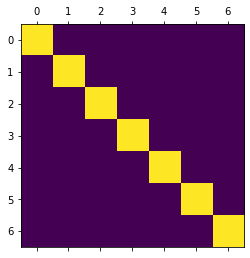

In [13]:
# D^l_mm is orthogonal
plt.matshow(np.real(np.conjugate(rotation_d.T)@rotation_d))

Note that given that librascal computes features in terms of real spherical harmonics, we have to convert back to complex-valued coefficients, using the utility functions `c2r` and `r2c` from `cg_utils`.

Note also that strictly speaking calling `r2c` on the coefficients from librascal yields objects that transform as $Y^m_l$, and not their complex-conjugates - so in fact we are computing the equivariants $\langle n| A; \overline{\rho_i^{\otimes 1}; lm} \rangle \equiv \langle nlm|A; \rho_i \rangle^\star$ (see again [Musil et al. (2021)](http://doi.org/10.1021/acs.chemrev.1c00021))

In [14]:
#  back and forth to check transformation from real to complex SPH
c2r(r2c(ref_feats[0,0,0,lm_slice(sel_l)])) - ref_feats[0,0,0,lm_slice(sel_l)]

array([0., 0., 0., 0., 0., 0., 0.])

Rotating the coefficients using the Wigner D matrix formula
$\langle n| A; \overline{\rho_i^{\otimes 1}; lm} \rangle  = 
\sum_{mm'} D^l_{mm'}(\hat{R})^\star \langle n| A; \overline{\rho_i^{\otimes 1}; lm'} \rangle 
$ gives features that are equal to those of the rotated structure

In [15]:
ref_feats[0,0,0,lm_slice(sel_l)]

array([  49.95020279,    3.36703957,  -14.28548994,  -32.00290346,
       -349.96433675,   38.64396967,  463.2326373 ])

In [16]:
ref_feats_rot[0,0,0,lm_slice(sel_l)]

array([-338.27822103,  120.03789117, -197.39407574,  213.54642541,
         35.9708892 ,  273.35856284,  229.9150595 ])

In [17]:
# some bookkeeping is needed to convert back to real
c2r(np.conjugate(rotation_d)@r2c(ref_feats[0,0,0,lm_slice(sel_l)]))

array([-338.27822103,  120.03789117, -197.39407574,  213.54642541,
         35.9708892 ,  273.35856284,  229.9150595 ])

## Direct real transformations

There's no "real" reason to go through the complex algebra for rotations - we can transform once and for all the coefficients and be done with that!

Key idea is that the complex $\leftrightarrow$ real transformations can be formulated in a matrix form

In [18]:
# matrix version of the real-2-complex and complex-2-real transformations
r2c_mat = real2complex_matrix(sel_l)
c2r_mat = np.conjugate(r2c_mat.T)

.... which can be used to transform features between complex and real

In [19]:
# we can use this to transform features
r2c_mat@ref_feats[0,0,0,lm_slice(sel_l)] - r2c(ref_feats[0,0,0,lm_slice(sel_l)])

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

... but can also be applied to matrices that act on the features

In [20]:
# and Wigner D matrix as well
real_rotation_d = np.real(c2r_mat @ np.conjugate(rotation_d) @ r2c_mat)

The direct real rotation is equal (modulo noise) to going back and forth from complex sph

In [21]:
real_rotation_d @ ref_feats[0,0,0,lm_slice(sel_l)] - ref_feats_rot[0,0,0,lm_slice(sel_l)]

array([ 3.97903932e-13, -6.25277607e-13,  0.00000000e+00, -6.25277607e-13,
       -1.84741111e-13, -7.95807864e-13, -5.40012479e-13])

# Clebsch-Gordan iteration

CG coefficients $\langle l_1 m_1; l_2 m_2 | LM\rangle$ are essential in the quantum theory of angular momentum, describing the combination of two angular momentum kets to form a coupled basis
$$
\sum_{m_1,m_2} |l_1m_1\rangle|l_2m_2\rangle \langle l_1 m_1; l_2 m_2 | LM\rangle = |LM\rangle
$$
They are also useful to combine equivariant objects so that the resulting object is still equivariant. This is the idea behind NICE iteration [Nigam et al., JCP (2020)](http://doi.org/10.1063/5.0021116)]
$$
\langle Q; nlk|\overline{\rho^{\otimes \nu+1}_i; \lambda\mu}\rangle = 
\sum_{m q} \langle n | \overline{\rho^{1}_i; lm}\rangle
\langle Q|\overline{\rho^{\otimes \nu}_i; kq}\rangle 
\langle lm; kq | \lambda\mu \rangle
$$
as well as equivariant neural networks.
The relationship to NICE as well as to more established features is demonstrated in more detail in [a dedicated notebook ](nice_demo.ipynb), while here we focus on how tre result of a CG iteration applied to equivariant features is also equivariant.

In [22]:
# these are the l indices of the features being combined, and that of the result
sl1, sl2, sL = 3, 2, sel_l
# computes the corresponding CG coefficient
cg = clebsch_gordan(sl1, sl2, sL)

This is an example of the application of the CG iteration to two equivariants of structure $A$, and to the corresponding features in the rotated structure $\hat{R}A$. 

In [23]:
cg_feats = np.einsum("abc,a,b->c", cg,
                    r2c(ref_feats[0,0,0,lm_slice(sl1)]), 
                    r2c(ref_feats[0,0,0,lm_slice(sl2)]))

In [24]:
cg_feats_rot = np.einsum("abc,a,b->c", cg,
                    r2c(ref_feats_rot[0,0,0,lm_slice(sl1)]), 
                    r2c(ref_feats_rot[0,0,0,lm_slice(sl2)]))

In [25]:
cg_feats

array([-146142.48296142+19487.08435407j,  -13059.66072498  +849.20883661j,
        111163.31700668 -4134.19856383j,   12867.0974336     +0.j        ,
       -111163.31700668 -4134.19856383j,  -13059.66072498  -849.20883661j,
        146142.48296142+19487.08435407j])

In [26]:
cg_feats_rot

array([-75001.05514463-106187.06439947j, -84287.78388905 +38917.28626367j,
       -13135.68077861 -63284.46149311j, -96628.12885381     +0.j        ,
        13135.68077861 -63284.46149311j, -84287.78388905 -38917.28626367j,
        75001.05514463-106187.06439947j])

The result is equivariant, in that the CG features of $\hat{R}A$ can be obtained by applying the usual Wigner D multiplication to the CG features of $A$

In [27]:
np.conjugate(rotation_d)@cg_feats - cg_feats_rot

array([ 3.34694050e-10+3.49245965e-10j,  4.36557457e-10-2.18278728e-10j,
        7.27595761e-12+1.45519152e-10j,  4.07453626e-10+0.00000000e+00j,
       -3.63797881e-12+1.45519152e-10j,  4.22005542e-10+2.18278728e-10j,
       -3.34694050e-10+3.49245965e-10j])

## Real form of the iteration

Similarly to the Wigner rotation, the CG iteration can also be cast in a way so it acts directly on the real-valued coefficients

In [28]:
r2c_mat_l1 = real2complex_matrix(sl1)
r2c_mat_l2 = real2complex_matrix(sl2)
r2c_mat_L = real2complex_matrix(sL)

computing the real-valued CGs requires converting in the appropriate way inputs AND outputs

In [29]:
real_cg = np.real(np.einsum("abc, ax, by, zc -> xyz", cg, r2c_mat_l1, r2c_mat_l2, np.conjugate(r2c_mat_L.T)))

while the "complex" CG have a simple sparsity pattern (m1+m2=M), the real-valued are kind of messy because they need to pick up and combine real and imaginary parts of the expansion coefficients

In [30]:
cg[:,:,2]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.40824829],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.        , -0.38729833,  0.        ,  0.        ],
       [ 0.        , -0.18257419,  0.        ,  0.        ,  0.        ],
       [ 0.63245553,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [31]:
real_cg[:,:,2]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.28867513],
       [ 0.        ,  0.        ,  0.        , -0.35355339,  0.        ],
       [ 0.        ,  0.        , -0.38729833,  0.        ,  0.4472136 ],
       [ 0.        , -0.18257419,  0.        ,  0.        ,  0.        ],
       [-0.4472136 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.35355339,  0.        ,  0.        ,  0.        ],
       [-0.28867513,  0.        ,  0.        ,  0.        ,  0.        ]])

... but at the end of the day, they work just fine!

In [32]:
real_cg_feats = np.einsum("abc,a,b->c",real_cg,
                    ref_feats[0,0,0,lm_slice(sl1)],
                    ref_feats[0,0,0,lm_slice(sl2)])

In [33]:
real_cg_feats - c2r(cg_feats)

array([ 3.63797881e-12,  4.54747351e-13, -2.72848411e-12,  0.00000000e+00,
       -5.82076609e-11,  3.63797881e-12,  5.82076609e-11])

needless to say, these are also equivariant, and can be acted upon with the real-valued wigner matrix

In [34]:
real_rotation_d @ real_cg_feats - c2r(cg_feats_rot)

array([-5.52972779e-10,  3.34694050e-10, -2.61934474e-10,  4.36557457e-10,
        1.81898940e-11,  6.54836185e-10,  5.23868948e-10])

# Streamlined WignerD, and CG class

The manipulations discussed above (and more!) can be realized using the utility classes defined in `rascal.utils`. In particular, 

`WignerDReal` is a Wigner D matrix implementation to rotate $Y^m_l$ - like coefficients. `WignerDReal` also allows rotating structures so you won't have to wonder about what Euler angle convention is being used ever again

`ClebschGordanReal` precomputes Clebsch-Gordan coefficients, and applies different kinds of related operations using real-only storage of the spherical expansion coefficients. 


In [35]:
# WignerDReal is initialized with the Euler angles of the rotation
WD = WignerDReal(spherical_expansion_hypers["max_angular"], *abc)
CG = ClebschGordanReal(spherical_expansion_hypers["max_angular"])

In [36]:
# prepares a list of features for different l's, just to use for testing
test_feats = [ ref_feats[0,0,0,lm_slice(l)]  for l in range(0,5) ]
test_feats_rot = [ ref_feats_rot[0,0,0,lm_slice(l)] for l in range(0,5) ]

## Rotation and CG iteration

`WignerDReal` can be used to rotate a frame (ASE or librascal internal format)

In [37]:
test_frame = WD.rotate_frame(selframe.copy())

In [38]:
test_frame.positions - rotframe.positions

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

`CG.combine` implements in the most straightforward manner the CG iteration that takes two equivariants, and produces and invariant of the specified L order. The order $l$ of the inputs is inferred by the size.

In [39]:
t1 = CG.combine(test_feats[3], test_feats[4], sel_l)
t1_r = CG.combine(test_feats_rot[3], test_feats_rot[4], sel_l)

The result can be rotated with the WignerD helper (and, ça va sans dire, matches the equivariant computed for the rotated structure)

In [40]:
WD.rotate(t1) - t1_r

array([ 1.45519152e-10, -1.41881173e-10,  2.91038305e-11, -1.52795110e-10,
       -3.63797881e-11, -1.74622983e-10, -1.45519152e-10])

Lots of fun: we can rinse, repeat as much as we want (the "I" in NICE is for "iterative"!)

In [41]:
t2 = CG.combine(t1, test_feats[3], 2)
t2_r = CG.combine(t1_r, test_feats_rot[3], 2)

In [42]:
WD.rotate(t2) - t2_r

array([ 5.58793545e-08,  7.07805157e-08,  3.72529030e-08, -2.37487257e-08,
        8.56816769e-08])

In [43]:
t3 = CG.combine(t2, test_feats[1], 1)
t3_r = CG.combine(t2_r, test_feats_rot[1], 1)

In [44]:
WD.rotate(t3) - t3_r # note: the residual grows only because the features become very large

array([ 1.22070312e-04, -4.10079956e-05, -3.33786011e-05])

A small twist: we can also combine two equivariants that are not expansion coefficients!

In [45]:
t4 = CG.combine(t3, t2, 3)
t4_r = CG.combine(t3_r, t2_r, 3)

In [46]:
(WD.rotate(t4) - t4_r)/np.linalg.norm(t4)

array([-6.71661849e-15,  3.38195931e-15, -3.83131055e-15,  4.87191341e-15,
        9.93302734e-16,  6.14901693e-15,  5.77061588e-15])

Note that the CG iter is built to fail gracefully if called with "impossible" inputs (e.g. with l1,l2,L that do not fulfill the triangle inequality)

In [47]:
CG.combine(t2, t4, 6)  #nb: t2 is L=2 and t4 is L=3

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

... but not when called outside the precomputed range 

In [48]:
# catch the exception because example notebooks should run without errors
try: 
    CG.combine(t2, t4, 12)
except ValueError:
    print("ValueError: Requested CG entry has not been precomputed")

ValueError: Requested CG entry has not been precomputed


# Feature products

Another common use of CG coefficients is to expand products of spherical harmonics into objects that transform as individual irreps of $SO(3)$. This is also implemented as part of `ClebschGordanReal`. These are basically outer products of the features $|l_1 m_1; l_2 m_2;\rangle = |l_1 m_1\rangle |l_2 m_2\rangle$

In [49]:
test_prod = test_feats[2][:,np.newaxis]@test_feats[3][np.newaxis,:]
test_prod_rot = test_feats_rot[2][:,np.newaxis]@test_feats_rot[3][np.newaxis,:]

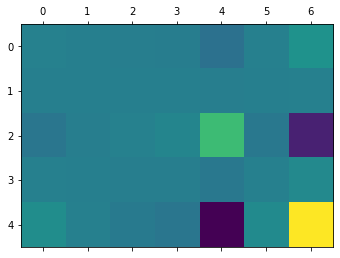

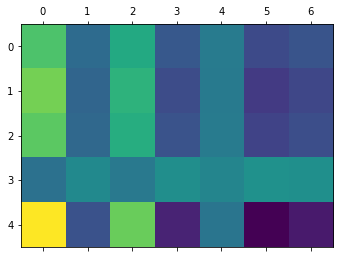

In [50]:
plt.matshow(test_prod); plt.show(); plt.matshow(test_prod_rot);

`ClebschGordanReal.couple()` takes one of these $l_1\times l_2$ matrices and explodes them as a list of terms with $L\in[|l_1-l_2|,(l_1+l_2)]$, i.e.
$$
|(l_1, l_2); L M\rangle = \sum_{m_1 m_2} |l_1 m_1 \rangle  |l_2 m_2 \rangle  \langle l_1 m_1; l_2 m_2 |L M \rangle
$$

In [51]:
test_coupled = CG.couple(test_prod)

Depending on the $l$ values this come from, the $L$ items have different nature (e.g. in terms of parity) and so the coupling function returns a dictionary in which each entry keeps track of the $l$ values of the terms that have been coupled

In [52]:
test_coupled

{(2, 3): {1: array([  1116.97266153,   9182.66418359, 257291.01929584]),
  2: array([  -35.01233816,  2828.86974201,   490.10996308, 14611.9089392 ,
          -767.50231429]),
  3: array([ -27558.89898463,   -1200.96265403,    5846.63967851,
           12867.0974336 ,  157208.67054923,  -18469.14931726,
         -206676.68144291]),
  4: array([  654.29805779, -7202.14472393,   362.06179569,  2653.03803833,
          1075.28740649,  8613.65658104, -1434.97953703, -8265.52573615,
           196.13187896]),
  5: array([  59173.23063602,    5671.61224113,  -26538.2726145 ,
           -3396.16257745,    8205.69769318,   23246.62736235,
          165340.37697962,  -31408.00297561, -178506.64997609,
           26363.61524319,  239148.83025647])}}

The coupled entries transform as $Y^m_l$ and can be rotated accordingly

In [53]:
test_coupled_rot = CG.couple(test_prod_rot)

In [54]:
test_coupled_rot[(2,3)][3]

array([ 150171.18662231,  -55037.35404483,   89497.74373103,
        -96628.12885381,  -18576.65790811, -119200.92711827,
       -106067.50937783])

In [55]:
WD.rotate(test_coupled[(2,3)][3]) - test_coupled_rot[(2,3)][3]

array([-5.23868948e-10,  3.27418093e-10, -2.32830644e-10,  4.36557457e-10,
        1.09139364e-11,  6.25732355e-10,  5.38420863e-10])

The coupled coefficients can be translated back into the product form

In [56]:
test_decoupled = CG.decouple(test_coupled)

In [57]:
test_decoupled

array([[ 5.03263807e+03,  3.39239694e+02, -1.43930748e+03,
        -3.22439192e+03, -3.52599939e+04,  3.89349997e+03,
         4.66721269e+04],
       [ 2.38554073e+02,  1.60804353e+01, -6.82251848e+01,
        -1.52840680e+02, -1.67137296e+03,  1.84557336e+02,
         2.21232400e+03],
       [-2.19349166e+04, -1.47858723e+03,  6.27326844e+03,
         1.40536170e+04,  1.53681829e+05, -1.69699462e+04,
        -2.03421982e+05],
       [ 2.64566849e+03,  1.78339026e+02, -7.56646992e+02,
        -1.69506966e+03, -1.85362535e+04,  2.04682118e+03,
         2.45356360e+04],
       [ 3.70114583e+04,  2.49486564e+03, -1.05850785e+04,
        -2.37130995e+04, -2.59312070e+05,  2.86339113e+04,
         3.43240157e+05]])

In [58]:
test_decoupled - test_prod

array([[-1.27329258e-11,  4.20641300e-12, -4.77484718e-11,
         1.81898940e-12,  1.45519152e-11, -2.27373675e-12,
        -2.18278728e-11],
       [-1.50635060e-12,  3.23474580e-11, -1.70530257e-12,
        -3.46744855e-12,  6.82121026e-13,  0.00000000e+00,
        -1.36424205e-12],
       [ 1.09139364e-11,  1.36424205e-12, -2.72848411e-12,
         1.81898940e-12, -5.82076609e-11,  7.27595761e-12,
         2.91038305e-11],
       [-1.36424205e-12,  3.52429197e-12,  3.41060513e-13,
         6.82121026e-13,  1.09139364e-11,  3.68345354e-11,
        -1.45519152e-11],
       [-2.18278728e-11, -1.36424205e-12,  7.27595761e-12,
         7.27595761e-12,  1.16415322e-10, -1.09139364e-11,
        -1.74622983e-10]])

In [59]:
np.linalg.norm(test_decoupled - test_prod)/np.linalg.norm(test_prod)

4.617687713775866e-16

This is a consequence of the fact that the real CG are orthogonal, just like their conventional counterparts

In [60]:
# this also gives a view into the internal storage of the CG coefficients, that are stored in a
# sparse format because of the non-trivial sparsity pattern
l1,l2 = next(iter(test_coupled.keys()))
prod = np.zeros((2*l1+1,2*l2+1,2*l1+1,2*l2+1))
for L in range(abs(l1-l2), abs(l1+l2)+1):
    for M in range(0, 2*L+1):
        for m1, m2, mcg in CG._cgdict[(l1, l2, L)][M]:
            for m1p, m2p, mcgp in CG._cgdict[(l1, l2, L)][M]:
                prod[m1,m2,m1p,m2p] += mcg*mcgp

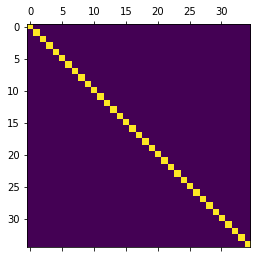

In [61]:
pr = prod.reshape((2*l1+1)*(2*l2+1),(2*l1+1)*(2*l2+1))
plt.matshow(pr)

## Higher products

The coupling/decoupling machinery can be applied also to higher products $\prod |l_i m_i\rangle$, in an iterative fashion

In [62]:
# this is a pretty complicated product
test_prod = np.einsum("a,b,c,d->abcd",test_feats[2],test_feats[1],test_feats[1],test_feats[2])

In [63]:
test_coupled = CG.couple(test_prod, iterate=2)

There are MANY terms, but all transform as the associated $Y^M_L$. The dictionary keys are composed according to the sequence of $l$ channels that were coupled.

In [64]:
list(test_coupled.keys())

[(2, 0, 1, 1, 1, 2),
 (2, 1, 1, 1, 1, 2),
 (2, 2, 1, 1, 1, 2),
 (2, 1, 1, 2, 1, 2),
 (2, 2, 1, 2, 1, 2),
 (2, 3, 1, 2, 1, 2),
 (2, 2, 1, 3, 1, 2),
 (2, 3, 1, 3, 1, 2),
 (2, 4, 1, 3, 1, 2)]

In [65]:
test_coupled[(2,  1,  1,  1, 1,  2)][3]

array([-2.72168001e+08, -3.82663120e+08,  5.22820035e+07,  2.13767186e+09,
       -3.40704335e+08, -2.68524386e+09,  1.75586816e+08])

In [66]:
test_prod_rot = np.einsum("a,b,c,d->abcd",test_feats_rot[2],test_feats_rot[1],test_feats_rot[1],test_feats_rot[2])
test_coupled_rot = CG.couple(test_prod_rot, iterate=2)

In [67]:
WD.rotate(test_coupled[(2,  1,  1,  1, 1,  2)][3]) - test_coupled_rot[(2,  1,  1,  1, 1,  2)][3]

array([-2.26497650e-05, -3.00407410e-05, -3.71932983e-05, -2.02655792e-05,
       -7.45058060e-07, -1.69277191e-05, -1.00135803e-05])

even if it's really messy behind the scenes, even this nested coupling sequence can be undone exactly (provided there's sufficiently high LMAX)

In [68]:
test_decoupled = CG.decouple(test_coupled, iterate=2)

In [69]:
np.linalg.norm(test_decoupled-test_prod)/np.linalg.norm(test_prod)

1.399719604561288e-15

## An application: irreducible spherical tensors

 Cartesian tensors (products of terms transforming like $x,y,z$) transform as a combination of rotation matrices. They can instead be decomposed in and _irreducible spherical tensor_ form, that instead transforms like irreps of $SO(3)$

In the following we see the decomposition of the simplest Cartesian tensor of rank 2, a dyadic formed from two atomic vectors
$$ 
\mathbf{X}_{ij} = \mathbf{u}_i \mathbf{v}_j  
$$
that can be decomposed into objects that transform as irreducible spherical tensors as 
$$
\mathbf{u}_i \mathbf{v}_j  = \frac{\mathbf{u} \cdot \mathbf{v}}{3} \delta_{ij}+ \frac{\mathbf{u}_i\mathbf{v}_j - \mathbf{u}_j \mathbf{v}_i}{2} + \left( \frac{\mathbf{u}_i\mathbf{v}_j + \mathbf{u}_j \mathbf{v}_i}{2} -\frac{\mathbf{u} \cdot \mathbf{v}}{3} \delta_{ij} \right)
$$
The first term on the RHS is an l=0 invariant, followed by an antisymmetric l=1 and a symmetric traceless l=2 tensor. 

For instance, take the product of atomic vectors

In [70]:
xx = selframe.positions.T @ selframe.positions

this converts xyz arrays to the outer product of two spherical l=1 form, so we can use the CG machinery

In [71]:
xx_spherical = xyz_to_spherical(xx)

In [72]:
xx_spherical

array([[ 99.50164592,  90.12413634,  91.93834919],
       [ 90.12413634,  91.5644164 ,  90.03734198],
       [ 91.93834919,  90.03734198, 111.39964704]])

the outer product of (xyz) decomposes as L=0+L=2 (L=1 is missing because of symmetry)

In [73]:
xx_coupled = CG.couple(xx_spherical)

In [74]:
xx_coupled

{(1, 1): {0: array([-174.62865872]),
  1: array([0., 0., 0.]),
  2: array([130.02046033, 127.45477591, -11.33805938, 127.33203014,
           8.41315727])}}

we can build the rotated tensor by rotating the irreducible representations. note that CG.decouple is smart enough to ignore the missing L=1 component (that would be full of zeros!)

In [75]:
xx_rot_wd = {(1,1) : {
                    0: xx_coupled[(1,1)][0], 
                    2: WD.rotate(xx_coupled[(1,1)][2]) 
                    }
                }
xx_rot_wd = spherical_to_xyz(CG.decouple(xx_rot_wd))

This matches the corresponding tensor computed for the rotated frame

In [76]:
xx_rot = rotframe.positions.T @ rotframe.positions

In [77]:
print(xx_rot)

[[ 47.373037   -80.92115493 -57.27908519]
 [-80.92115493 169.73100427 105.02452214]
 [-57.27908519 105.02452214  85.36166809]]


In [78]:
print(xx_rot_wd)

[[ 47.373037   -80.92115493 -57.27908519]
 [-80.92115493 169.73100427 105.02452214]
 [-57.27908519 105.02452214  85.36166809]]
